In [39]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
import string

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv(r'C:\Users\niyai\git\british-analysis\data\British_Airway_Review_cleaned.csv')

In [29]:
stop_words = set(STOPWORDS)
stop_words.update(['ba', 'flight', 'flights', 'british', 'airway', 'airways'])

In [53]:
def extractwords(df):
    # into a single string text, with each review separated by a space
    text = " ".join(review for review in df.cleaned_reviews)

    # remove all punctuation characters from the text
    text = text.translate(str.maketrans('', '', string.punctuation))

    # removing any extra whitespace and ensuring that the list only contains non-empty words
    cleaned_words = [word for word in text.split() if word.strip()]

    # convert into lowercase
    # checking words against stopwords
    cleaned_words = [word.lower() for word in cleaned_words if word.lower() not in stop_words]

    word_freq = pd.Series(cleaned_words).value_counts()
    df_word_freq = word_freq.reset_index()
    df_word_freq.columns = ['Word', 'Frequency']
    return df_word_freq

In [59]:
df_yes = pd.DataFrame(df[df['recommended'] == 'Yes']['cleaned_reviews'])
df_no = pd.DataFrame(df[df['recommended'] == 'No']['cleaned_reviews'])

In [67]:
df_concatenated = pd.concat([extractwords(df_yes), extractwords(df_no)], keys=['Yes', 'No'])

In [68]:
df_concatenated['Recommended'] = df_concatenated.index.get_level_values(0)

In [70]:
df_concatenated = df_concatenated.reset_index(drop=True) # remove keys

In [94]:
topwords = extractwords(df).head(50).Word 

In [95]:
df_topwords = df_concatenated[df_concatenated['Word'].isin(topwords.values)]

In [96]:
# Plot the treemap
fig_wr = px.treemap(df_topwords, path=['Word', 'Recommended']
                 , values='Frequency', title='Most Frequent Words')
fig_wr.update_layout(title_x = 0.5, 
                  margin = dict(l = 50, r = 40, t = 50, b = 30)
                  )
# fig.update_traces(marker=dict(colorscale='RdBu', cmax=df_word_freq['Frequency'].head(50).max()))

In [142]:
# Plot the treemap
fig_rw = px.treemap(df_topwords, path=['Recommended','Word']
                 , values='Frequency', title='Most Frequent Words',
                 color = 'Recommended',
                 color_discrete_map={'No':'red', 'Yes':'green'}
                 )
fig_rw.update_layout(title_x = 0.5, 
                  margin = dict(l = 50, r = 40, t = 50, b = 30)
                  )


In [123]:
average_score = df_topwords.Frequency.mean()

In [137]:

parents = ['']*len(df_topwords['Word'])

In [140]:
go.Figure(go.Treemap(
    parents = df_topwords['Recommended'],
    # parents = parents,
    values = df_topwords['Frequency'],
    labels = df_topwords['Word'],
    )
)

In [ ]:
#  hovertemplate='<b>%{label} </b> <br> Sales: %{value}<br> Success rate: %{color:.2f}',

(-0.5, 1599.5, 799.5, -0.5)

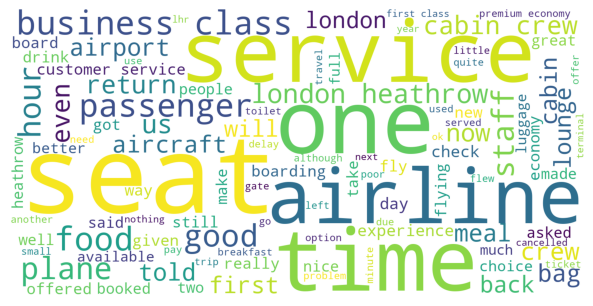

In [69]:
wc = WordCloud(background_color='white',max_words=100,max_font_size=300,width=1600,height=800, stopwords=stop_words)
wc.generate(" ".join(cleaned_words))

plt.imshow(wc)
plt.tight_layout()
plt.axis('off')

In [70]:
# # Extract the pixel data from the matplotlib figure
# fig = go.Figure()
# for i in range(len(plt.gca().collections)):
#     paths = plt.gca().collections[i].get_paths()
#     for path in paths:
#         if len(path.vertices) > 2:
#             x, y = zip(*path.vertices)
#             fig.add_trace(go.Scatter(x=x, y=y, mode='lines', fill='toself', line=dict(width=0)))

# # Update layout to remove axes and set background color
# fig.update_layout(
#     xaxis=dict(showgrid=False, showticklabels=False, zeroline=False, range=[0, 1600]),
#     yaxis=dict(showgrid=False, showticklabels=False, zeroline=False, range=[0, 800]),
#     # plot_bgcolor='white'
# )

# # Show the Plotly figure
# fig.show()

In [71]:
df['tb_polarity'] = df['cleaned_reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['tb_subjectivity'] = df['cleaned_reviews'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [72]:
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

In [73]:
df['tbp_analysis'] = df['tb_polarity'].apply(getAnalysis )

In [74]:
df.groupby(['tbp_analysis']).size().reset_index(name='count')

,tbp_analysis,count
0,Negative,793
1,Neutral,13
2,Positive,1694


In [75]:
df_textblob = df.groupby(['recommended', 'tbp_analysis']).size().reset_index(name='count')

chart_textblob = px.bar(
    df_textblob,
    x = "recommended",
    y = "count",
    color = 'tbp_analysis',
    barmode = 'group', text_auto=True,
    color_discrete_map = {'Negative': 'red', 'Neutral': 'blue', 'Positive': 'green'}
)
chart_textblob


In [76]:
df_textblob = df.groupby(['ym', 'tbp_analysis']).size().reset_index(name='count')

chart_textblob = px.line(
    df_textblob,
    x = "ym",
    y = "count",
    color = 'tbp_analysis',
    color_discrete_map = {'Negative': 'red', 'Neutral': 'blue', 'Positive': 'green'}
)
chart_textblob


In [77]:
sentiment = SentimentIntensityAnalyzer()

In [78]:
df['v_polarity'] = df['cleaned_reviews'].apply(lambda x: sentiment.polarity_scores(x))
df['v_compound']  = df['v_polarity'].apply(lambda score_dict: score_dict['compound'])
df['v_comp_score'] = df['v_compound'].apply(lambda c: 'Positive' if c > 0 else ('Neutral' if c == 0 else 'Negative'))


In [79]:
df.groupby(['v_comp_score']).size().reset_index(name='count')

,v_comp_score,count
0,Negative,1123
1,Neutral,6
2,Positive,1371


In [80]:
df_vader = df.groupby(['recommended', 'v_comp_score']).size().reset_index(name='count')

chart_vader = px.bar(
    df_vader,
    x = "recommended",
    y = "count",
    color = 'v_comp_score',
    barmode = 'group', text_auto=True,
    color_discrete_map = {'Negative': 'red', 'Neutral': 'blue', 'Positive': 'green'}
)
chart_vader


In [81]:
# df[(df['stars'] == 1) & (df['v_comp_score'] == 'Positive')]['cleaned_reviews']

In [82]:
v_test = df.groupby(['ym', 'v_comp_score']).size().reset_index(name='count')

px.line(
    v_test,
    x = "ym",
    y = "count",
    color = 'v_comp_score',
    color_discrete_map = {'Negative': 'red', 'Neutral': 'blue', 'Positive': 'green'}
)